In [1]:
import os
os.environ["TRANSFORMERS_OFFLINE"] ="1"
os.environ["TRANSFORMERS_CACHE"] = "/home/gridsan/groups/maia_mechint/models"

In [2]:
cd ../

/home/gridsan/cguo/rep_e_icl/rep_e_icl


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from repe import repe_pipeline_registry
repe_pipeline_registry()
from tasks import get_task_dataset
from modules import *

In [5]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [7]:
dataset_name = 'rotten_tomatoes'
positive_prompt = "Pay attention to the following examples."
negative_prompt = "Don't pay attention to the following exmaples."
ntrain = 64 
test_num_examples = 2
user_tag = "[INST]"
assistant_tag = "[/INST]"
dataset = get_task_dataset(dataset_name, tokenizer, positive_prompt, negative_prompt, ntrain=ntrain, test_num_examples=test_num_examples)

getting dataset for rotten_tomatoes
['negative', 'positive']
data len: 32
['negative', 'positive']
data len: 32
['negative', 'positive']
data len: 533


In [8]:
dataset["train"]["data"][1]

'Don\'t pay attention to the following exmaples. LlamaTokenizer(name_or_path=\'meta-llama/Llama-2-7b-hf\', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side=\'left\', truncation_side=\'right\', special_tokens={\'bos_token\': \'<s>\', \'eos_token\': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'unk_token\': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'pad_token\': \'<unk>\'}, clean_up_tokenization_spaces=False) [INST] it\'s pretentious in a way that verges on the amateurish .\nnegative\nana is a vivid , vibrant individual and the movie\'s focus upon her makes it successful and accessible .\npositive\n'

In [9]:
(dataset["test"]["data"][1], dataset["test"]["labels"][1])

("[INST] [/INST] rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .\npositive\nbeneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .\n",
 'positive')

In [10]:
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)
rep_reader = get_rep_reader(model, rep_reading_pipeline, dataset)

["Don't pay attention to the following exmaples. Pay attention to the following examples. [INST] too silly to be frightening , too stolid to be funny , it projects the same lazy affability as its nominal star , david arquette .\nnegative\noften hilarious , well-shot and , importantly , entertaining , hell house is a fascinating document of an event that has to be seen to be believed .\npositive\n", 'Don\'t pay attention to the following exmaples. LlamaTokenizer(name_or_path=\'meta-llama/Llama-2-7b-hf\', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side=\'left\', truncation_side=\'right\', special_tokens={\'bos_token\': \'<s>\', \'eos_token\': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'unk_token\': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'pad_token\': \'<unk>\'}, clean_up_tokenization_spaces=False) [INST] it\'s pretentious in a way that verges on the a

In [11]:
dataset["test"]["data"]

['[INST] [/INST] compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .\npositive\nthe soundtrack alone is worth the price of admission .\n',
 "[INST] [/INST] rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .\npositive\nbeneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .\n",
 "[INST] [/INST] bielinsky is a filmmaker of impressive talent .\npositive\nso beautifully acted and directed , it's clear that washington most certainly has a new career ahead of him if he so chooses .\n",
 '[INST] [/INST] a visual spectacle full of stunning images and effects .\npositive\na gentle and engrossing character study .\n',
 "[INST] [/INST] it's enough to watch huppert scheming , with her small , intelligent eyes as steady as any noir villain , and to

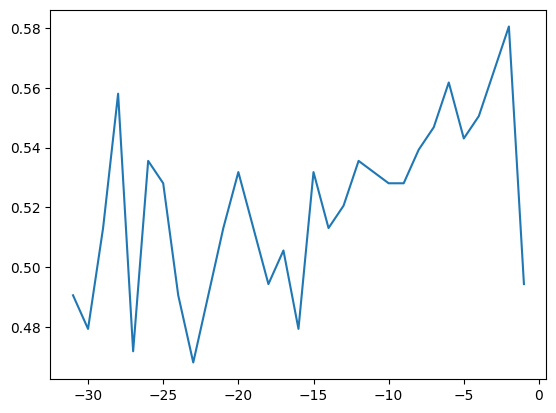

In [12]:
hidden_layers = get_hidden_layers(model)
H_tests = get_h_test(
    model, 
    rep_reading_pipeline, 
    rep_reader, 
    dataset
)
plot_correlation(rep_reader, H_tests, hidden_layers)

In [13]:
data = dataset["test"]["data"][1]
test_data = get_test_data(model, tokenizer, [data])
wanted_layers = range(-10, -25, -1)
rep_reader_scores_dict, rep_reader_scores_mean_dict = get_rep_reader_scores_dict(model, tokenizer, 
                                                                                 rep_reading_pipeline, 
                                                                                 rep_reader, 
                                                                                 test_data, wanted_layers=wanted_layers )

In [14]:
THRESHOLD = 0.0 # change this to alter sensitivity
input_ids = tokenizer.tokenize(test_data[0])

In [15]:
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(20, -20))

ValueError: '▁I' is not in list

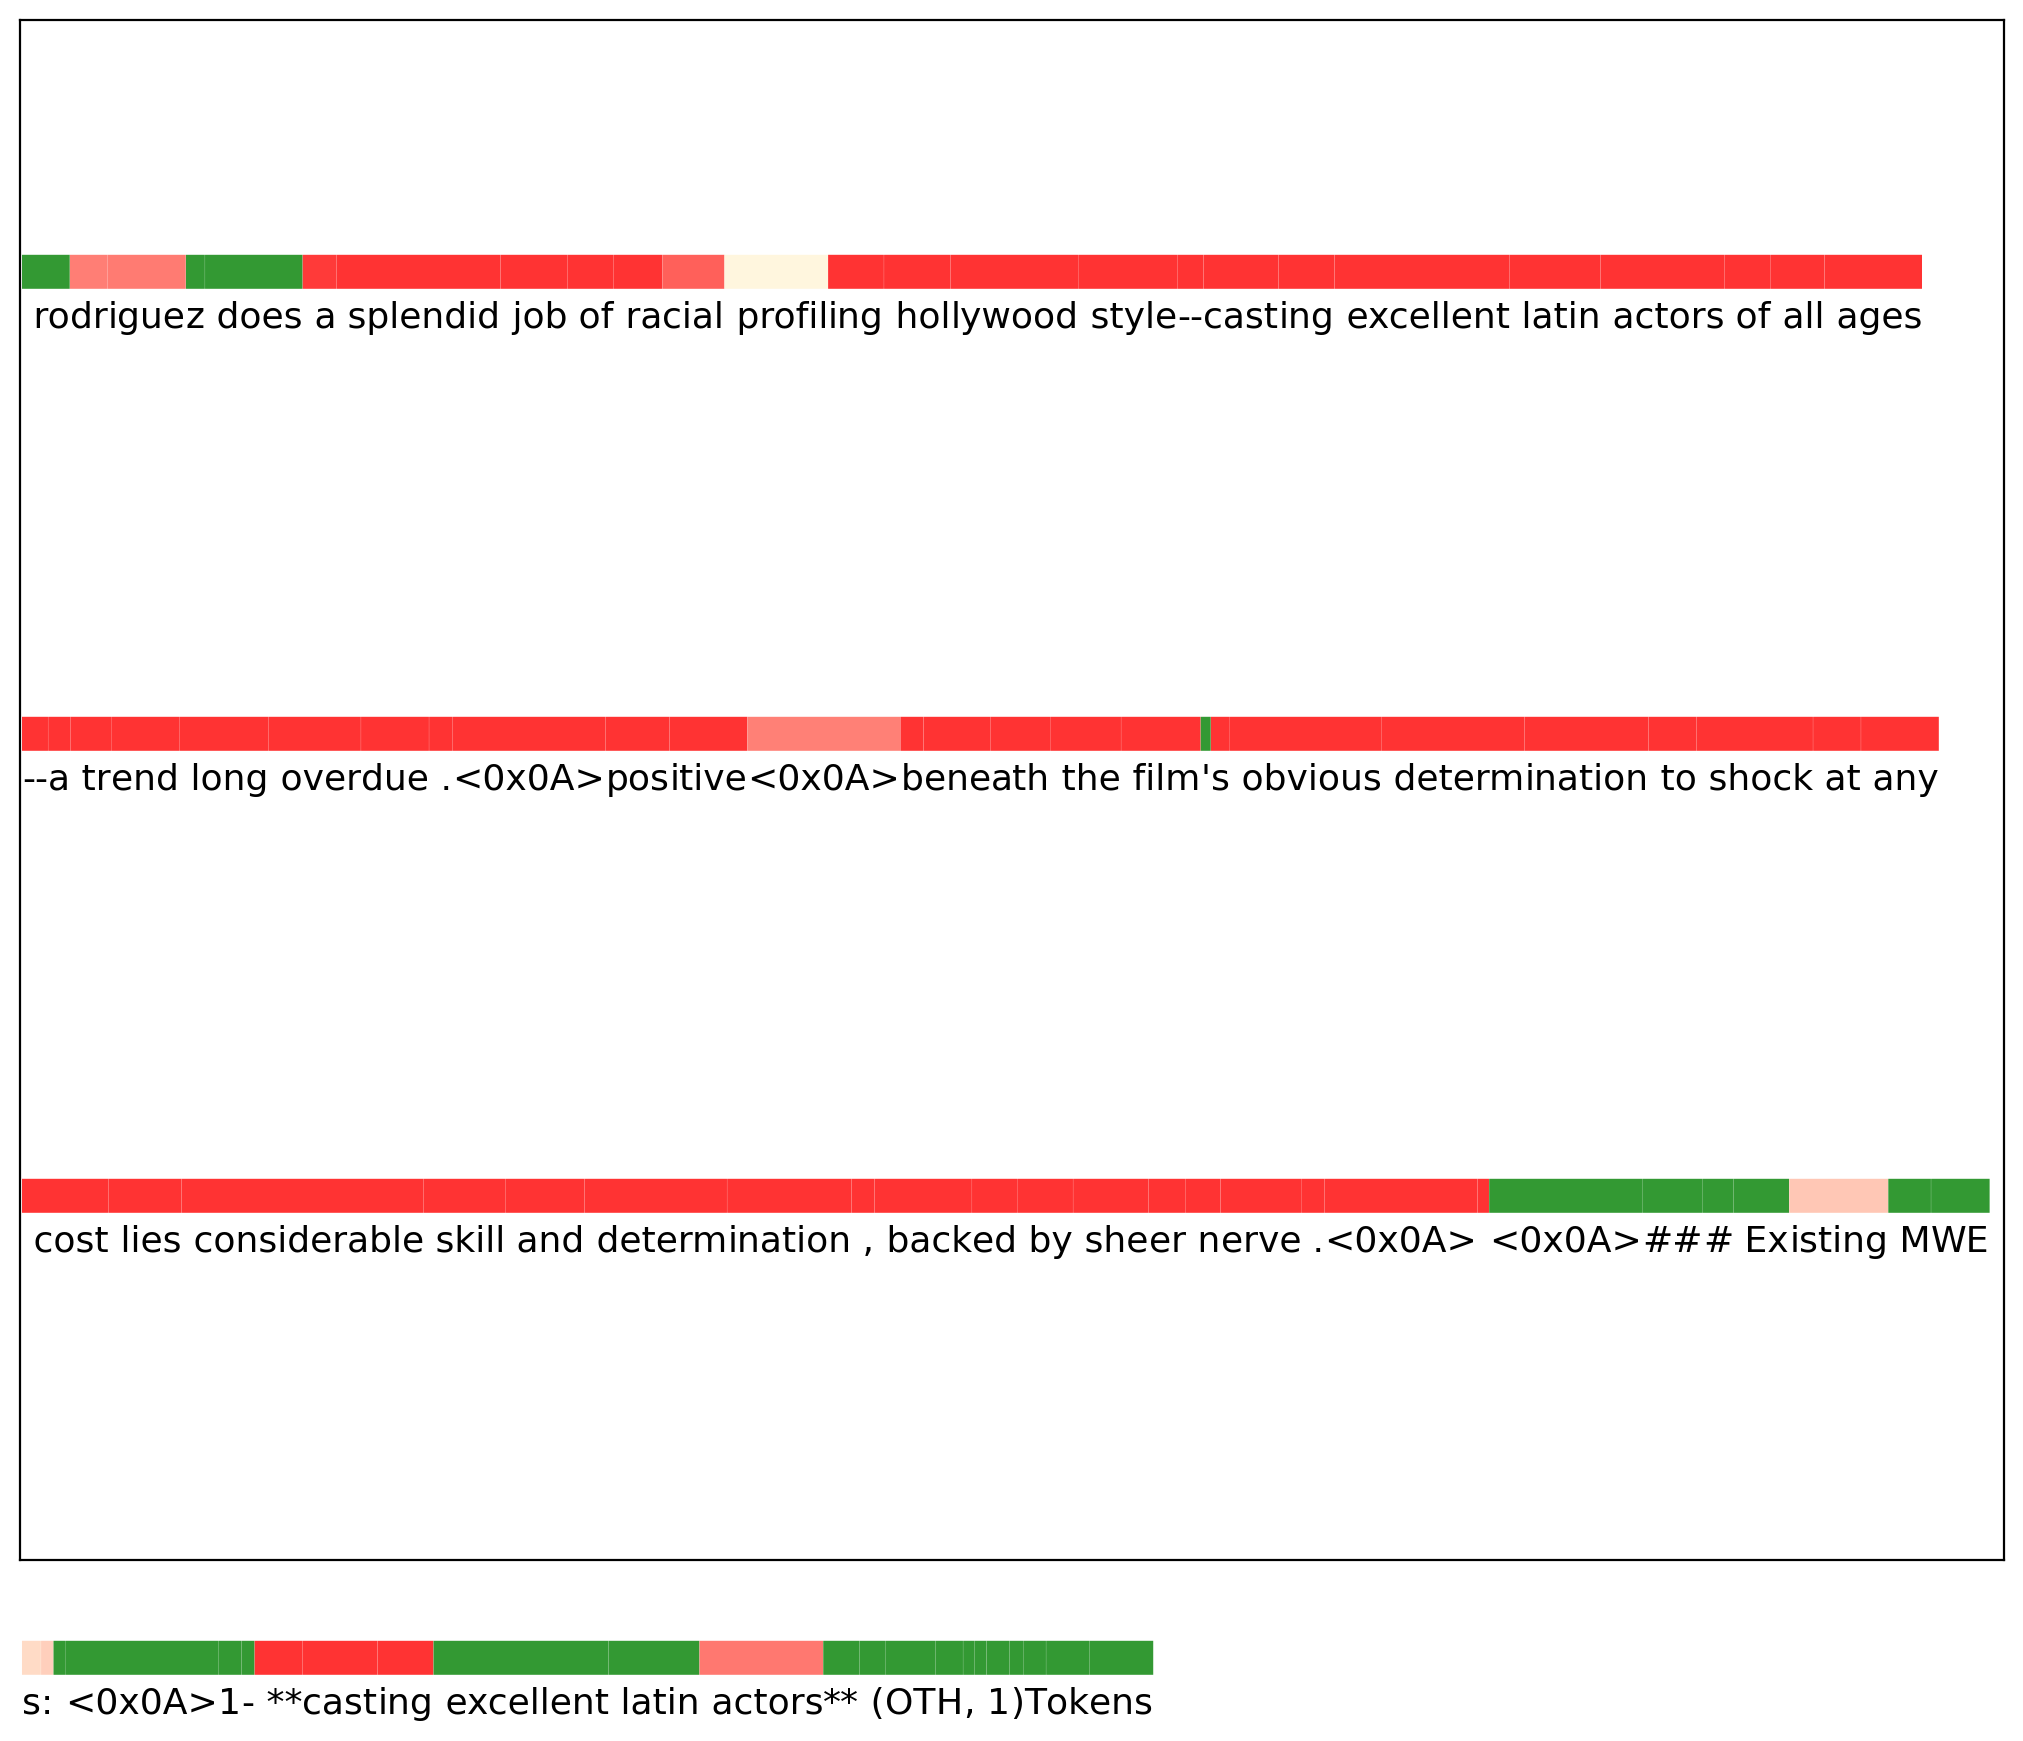

In [16]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

In [34]:

max_layer = -10
min_layer = -25

layer_id = list(range(max_layer, min_layer, -1))
rep_control = get_rep_control(model, tokenizer, layer_id)

In [35]:

baseline, pos_results, neg_results = get_rep_controlled_results(rep_reader, rep_control, dataset["test"]["data"], layer_id)

Done with baseline results!
Done with control outputs!


In [31]:
dataset["test"]["labels"][0]

'positive'

In [32]:
acc_dict = get_acc_dict(baseline, pos_results, neg_results, dataset["test"]["labels"])

.
.
n n n
.
.
.
.

...

.
.
!
!
jjj
.
.
...
...
...
...


\t\

.
.
.
.
...
.
.
...

...
...

h h h
.
.

.
.
.
.
d.d
.
.
...
. .
' ''
t t t
...
...
doll d
...
.
.
l l l
.
.
...
.
.
...
���

...
.
.
...
tg
.
.
\end\
.
.
.
.

...
.
.
soft
...
. 1

.a.
...
.
.
.
.
...
.
.
!!!

...
...
b b b
.
.
.
.
...
vibrant
'''
...
...

.
.

.
.
.
.
...
t t t
...
.
.
...
.
.
\\\
jjj
.
.
...
11
...
m m m
...
.
.
...
p tt
10
p p p
...
.
.
...
...
.t.
.
.
.
.
.
.
c c c
...
. .

vgv
.
.
uuu
h h h
.
.
frrfr

...

.
.
...
...
...
.
.
...
igigig
.
.
...
...
...
t t t
smacksm
t t t
...
e e e
ababab
tg g

.
.
...
.
.
...
...
...
...
...
...
...
.
.
w.t
d d d
k kk
jjj
ch ch ch

...
i ii
...
...

m m m
...
mgm
c c c
c c c
.
.

.
.
...

.
.

...
...
.
.

...
...
scatter sc
. �
...
. .
t t t
.
.
...
susp
.
.
...
clc c
t t t
.
.
.
.
...

...
i i i
...
m m m
d d d
m m m
vvv
. 1

...
.
.
.
.
...
.
.
t t t
.
.
...
gagag
???

!!!
...
.
.
g g g
icicic
.
.
t t t
...

a a a
. .
...
...


humpump
...
...
.
.
d d d
a a a
vvv


In [33]:
acc_dict

{'baseline_acc': 0.454, 'pos_acc': 0.0, 'neg_acc': 0.004}

In [24]:
for a, b, c in zip(baseline, pos_results, neg_results): 
    print(a, b, c)
    print("-----")

negative
the positive a film that
-----
positive positive negative
the
-----
positive positive [INST]
-----
negative
a positive negative
a
-----
negative
the positive [INST]
-----
positive positive [INST]
-----
positive positive [INST]
-----
negative
a positive [INST]
-----
positive positive [INST]
-----
negative
the negative negative
the
-----
positive positive a witt
-----
positive positive positive
-----
positive positive negative
the
-----
positive positive the film'
-----
positive positive [INST]
-----
positive positive [INST]
-----
positive positive the director'
-----
positive positive [INST]
-----
negative
the positive [INST]
-----
positive positive [INST]
-----
positive positive a witt
-----
positive positive a taut
-----
negative
t positive [INST]
-----
positive positive a film that
-----
positive positive positive
-----
negative
the positive negative
the
-----
negative
the positive negative
a
-----
negative
the positive [INST]
-----
**_The Author: j The remake
-----
positive